In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.genmod import families
import seaborn as sns

In [2]:
plt.rcParams["figure.figsize"] = (12,8)

In [3]:
df = pd.read_csv('../Datasets/DATA_3.02_HR2.csv')
df.head()

,S,LPE,NP,ANH,TIC,Newborn,left
0,0.38,0.53,2,157,3,0,1
1,0.80,0.86,5,262,6,0,1
2,0.11,0.88,7,272,4,0,1
3,0.72,0.87,5,223,5,0,1
4,0.37,0.52,2,159,3,0,1


As a reminder, our goal is to understand what distinguishes employees who stay in the company and those who leave the company.  

To do so we're going to explore a data set very similar to the one we had in week1. However, this time, we've added more employees, and more importantly, we've added an outcome variable which tells us if the employee indeed left or not.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   S        12000 non-null  float64
 1   LPE      12000 non-null  float64
 2   NP       12000 non-null  int64  
 3   ANH      12000 non-null  int64  
 4   TIC      12000 non-null  int64  
 5   Newborn  12000 non-null  int64  
 6   left     12000 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 656.4 KB


This time we have 12000 employees and the abbreviations associated with the variables stand for:
1. 'S': satisfaction, 
2. 'LPE': last project evaluation
3. 'NP': number of projects worked on by the employee in the last 12 months
4. 'ANH': the average numbers of hours worked weekly by the employee over the last 12 months
5. 'TIC': time spent in the company
6. the newborn variable which tells us whether or not the employee had a newborn within the last 12 month
7. and finally, our outcome variable which is called left. Which will take the value one if the employee indeed left and zero otherwise

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
S,"12,000.00",0.63,0.24,0.09,0.48,0.66,0.82,1.00
LPE,"12,000.00",0.72,0.17,0.36,0.57,0.72,0.86,1.00
NP,"12,000.00",3.80,1.16,2.00,3.00,4.00,5.00,7.00
ANH,"12,000.00",200.44,48.74,96.00,157.00,199.50,243.00,310.00
TIC,"12,000.00",3.23,1.06,2.00,2.00,3.00,4.00,6.00
Newborn,"12,000.00",0.15,0.36,0.00,0.00,0.00,0.00,1.00
left,"12,000.00",0.17,0.37,0.00,0.00,0.00,0.00,1.00


From the above table we can see that nearly 17% of our
employees have left the company. We can also see that 15.4% of the employees had a newborn within the last 12 month and also that, on average, employees have been in the company for 3.2 years.

In the next steps we are going to explore a bit more our data.

In [12]:
# Look at the frequency of the left variable
df.value_counts(subset='left', normalize=True)*100

left
0   83.33
1   16.67
dtype: float64

Here we see that 83% of the observations are employees who stayed in the company. While 17% of them are employees who left.

In [13]:
df.corr()

,S,LPE,NP,ANH,TIC,Newborn,left
S,1.00,0.10,-0.13,-0.01,-0.22,0.04,-0.35
LPE,0.10,1.00,0.27,0.27,0.12,-0.01,0.01
NP,-0.13,0.27,1.00,0.33,0.25,-0.01,0.03
ANH,-0.01,0.27,0.33,1.00,0.13,-0.01,0.07
TIC,-0.22,0.12,0.25,0.13,1.00,-0.02,0.27
Newborn,0.04,-0.01,-0.01,-0.01,-0.02,1.00,-0.13
left,-0.35,0.01,0.03,0.07,0.27,-0.13,1.00


Correlation only gives us information about the strength and the direction of the linear relationship between two variables. If we look at the correlation between the *left* variable and the others. We can see that satisfaction is
negatively correlated with it. TIC is very moderately positively correlated with it.  

Now, this does not tell us much about the nature of relationship and interactions among all the variables. That's why perform a logistic regression.

In [17]:
# Estimate a linear regression model of Rating 
# as a function of everything else
all_columns = "+".join(df.columns).replace('+left', '')
my_formula = 'left~' + all_columns

'left~S+LPE+NP+ANH+TIC+Newborn'

To build a logistic regression model, we use the glm function. Our first argument is the outcome
variable, for us it's left. You then insert a tilde followed by the variables you want to use to build your model. In our case, we'll use all the other variables. We then set the family argument
equal to binomial (logit) and then the data argument equal to our dataset.

The default link for the Binomial family is the logit link, I just wanted to show how to change it in case you want to play with other links as probit, cauchy, log, or cloglog 

In [44]:
logreg = smf.glm(my_formula, family=families.Binomial(link=families.links.logit()), data=df).fit()

Let's see the proportion of employees' attrition according to the model by building a histogram
of the fitted values.

<AxesSubplot:>

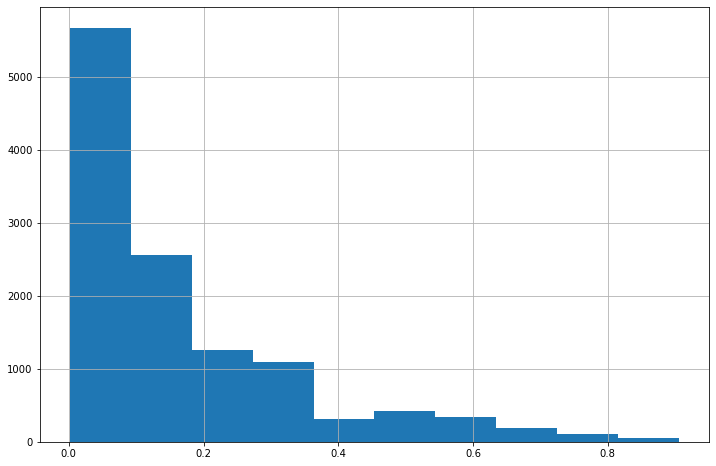

In [46]:
logreg.fittedvalues.hist()

The frequency is on the vertical axis while the fitted values, which are probabilities, are on the horizontal axis.

Now let's assess how the model is performing. We can start by assessing the correlation between the estimated attrition by the model and the actual one:

In [47]:
np.corrcoef(logreg.fittedvalues,df['left'])[0][1]

0.4052016575818631

Now, since the output of a logistic regression is a probability, that is a continuous variable that can take any value between zero and one. We need to set a value that tells us what we consider to be a leaver and what we consider a person who stays. This is called the cut off value.

In [48]:
# Cutoff to determine when P[leaving] should be considered as a leaver or not
cutoff=.5

Let's build the confusion matrix:

In [55]:
conf_mat = pd.crosstab(logreg.fittedvalues >= cutoff, df['left'])
conf_mat

left,0,1
row_0,,
False,9464,1619
True,536,381


Now what we see in the above matrix is:
* The left variable could be 0 or 1, where 0 means stayed and 1 left
* The logreg.fittedvalues >= cutoff could be true or false, where True means left and false means stayed.
* So we have 9464 employees who were predicted to stay and indeed stayed
* while 536 employees were predicted by the model to leave but in reality stayed


In [63]:
# The overall percentage of correctly classified employees by a cutoff=.5:
(conf_mat.iloc[0,0] +  conf_mat.iloc[1,1])/df.shape[0]

0.8204166666666667

In [58]:
logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   left   No. Observations:                12000
Model:                            GLM   Df Residuals:                    11993
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4254.5
Date:                Sat, 01 May 2021   Deviance:                       8508.9
Time:                        23:50:46   Pearson chi2:                 9.30e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2412      0.160     -7.751      0.000      -1.555      -0.927
S             -3.8163      0.121    -31.607      0.000      -4.053      -3.580
LPE            0.5044      0.181      2.788      0.005       0.150       0.859
NP            -0.3592      0.026    -13.569      0.000      -0.411      -0.307
ANH            0.0038      0.001      6.067      0.000       0.003       0.005
TIC            0.6188      0.027     22.820      0.000       0.566       0.672
Newborn       -1.4851      0.113    -13.157      0.000      -1.706      -1.264
==============================================================================
"""

In [67]:
# The greater the magnitude of T, the greater the evidence against the null hypothesis. 
# This means there is greater evidence that there is a significant difference
# Let's print them
logreg.tvalues

Intercept    -7.75
S           -31.61
LPE           2.79
NP          -13.57
ANH           6.07
TIC          22.82
Newborn     -13.16
dtype: float64

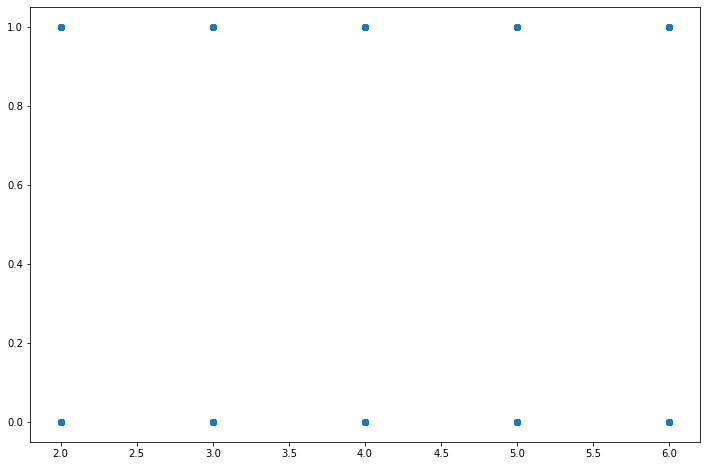

In [69]:
plt.scatter(df['TIC'], df['left'])
plt.xlabel('Time Spent')
plt.ylabel('Attrition')
plt.title('Time and Employee Attrition')

In [72]:
# Compute the average attrition rate for each value of TIC
aggbTimeRank = df[['TIC','left']].groupby('TIC').mean()
aggbTimeRank

,left
TIC,
2,0.01
3,0.17
4,0.24
5,0.44
6,0.21


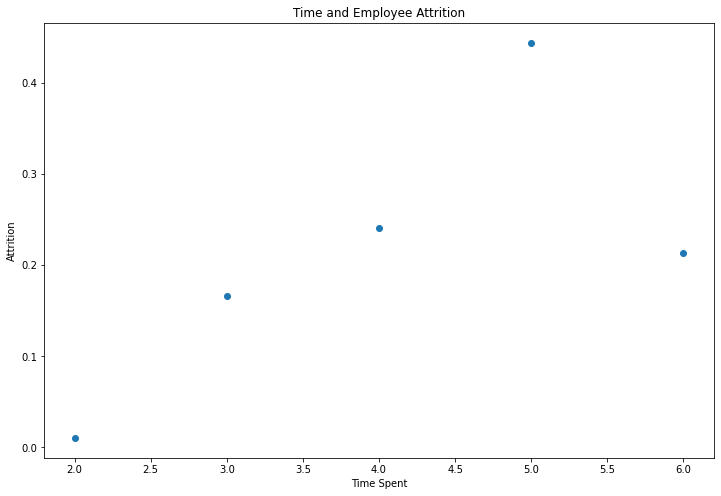

In [78]:
plt.scatter(aggbTimeRank.index, aggbTimeRank['left'])
plt.xlabel('Time Spent')
plt.ylabel('Attrition')
plt.title('Time and Employee Attrition');

So here we find out that attrition increases with the years spent in the company up to year five,
then, it decreases sharply. This is an interesting fact, so let's investigate further. We computed mean values, but we do not know how many employees each dot represents. So let's do that.

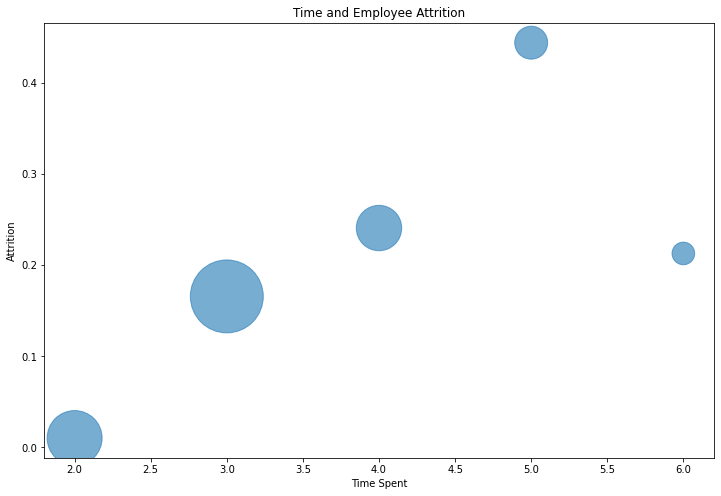

In [96]:
cntbTimeRank = df[['TIC','left']].groupby('TIC').count()
ax = plt.scatter(x=aggbTimeRank.index, y=aggbTimeRank['left'],s=cntbTimeRank['left'], alpha=.6)
plt.xlabel('Time Spent')
plt.ylabel('Attrition')
plt.title('Time and Employee Attrition');

In [97]:
tempdata = df.copy()

In [110]:
# We create categories of employee satisfaction raning. We create 20 groups
tempdata['rankSatis'] = round(tempdata['S'].rank(ascending=False)/600)

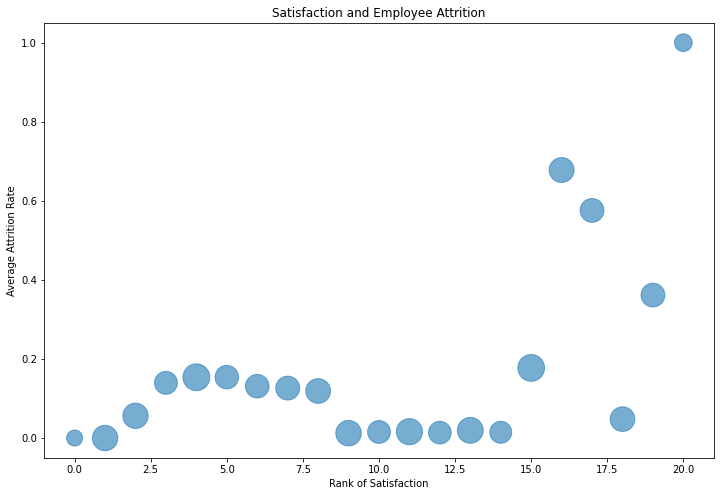

In [111]:
aggbSatisRank = tempdata[['left', 'rankSatis']].groupby('rankSatis').mean()
cntbSatisRank = tempdata[['left', 'rankSatis']].groupby('rankSatis').count()
ax = plt.scatter(x=aggbSatisRank.index, y=aggbSatisRank['left'],s=cntbSatisRank['left'], alpha=.6)
plt.xlabel('Rank of Satisfaction')
plt.ylabel('Average Attrition Rate')
plt.title('Satisfaction and Employee Attrition');